# Projet 7 : Implémentez un modèle de scoring


Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
 
 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Les données
Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

Votre mission : 
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Michaël, votre manager, vous incite à sélectionner un ou des kernels Kaggle pour vous faciliter l’analyse exploratoire, la préparation des données et le feature engineering nécessaires à l’élaboration du modèle de scoring. Si vous le faites, vous devez analyser ce ou ces kernels et le ou les adapterpour vous assurer qu’ils répond(ent) aux besoins de votre mission.


# 

## Sommaire

### I. Importation
#### 1. Importation des bibliothèques
#### 2. Importation des fichiers

### Modélisation
#### 1. Préparation des données
#### 2. Entrainement du modèle
#### 3. Optimisation du modèle

### Conclusion étape KNN

# 

### I. Importation

#### 1. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Preprocessing et standardisation
from sklearn.preprocessing import StandardScaler



# Séparation du jeu de données
from sklearn.model_selection import train_test_split


# Importation pour notre modélisation
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report



In [2]:
# Importation de notre dataframe
df = pd.read_csv('df_cleaning.csv', index_col=0)

In [3]:
df

,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,NEW_DOC_KURT,...,NONLIVINGAREA_MODE,AMT_ANNUITY,BURO_CREDIT_TYPE_Mortgage_MEAN,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,1,100002,0.0,0.522181,1.00000,6.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,24700.5,0.000000,24.00,0,0,40.500000,0,9251.775,49156.200000
1,0,100003,0.0,0.522181,1.00000,1.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,35698.5,0.000000,10.00,0,0,0.000000,0,6662.970,0.000000
2,0,100004,0.0,0.522181,1.00000,0.0,76645.791409,1.294235,0.014808,0.0,...,0.027023,6750.0,0.000000,4.00,0,0,2529.066951,0,5357.250,0.000000
3,0,100006,0.0,0.522181,1.00000,3.0,0.000000,1.294235,0.000000,20.0,...,0.027023,29686.5,0.014232,18.00,0,0,2529.066951,0,2482.920,160390.363993
4,0,100007,0.0,0.522181,1.00000,14.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,21865.5,0.000000,20.67,0,0,2529.066951,0,0.180,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,0,456251,0.0,0.522181,1.00000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.012500,27558.0,0.014232,8.00,0,0,2529.066951,0,6605.910,160390.363993
307502,0,456252,0.0,0.522181,1.00000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,12001.5,0.014232,6.00,0,0,2529.066951,0,10046.880,160390.363993
307503,0,456253,5.0,0.522181,1.00000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,29979.0,0.000000,5.00,0,0,2529.066951,0,27.270,448958.250000
307504,1,456254,0.0,0.522181,1.00000,12.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,20205.0,0.000000,15.00,0,0,2529.066951,0,2296.440,0.000000


In [4]:
# Création d'un jeu de données pour l'étape du Dashboard
import random

# Sélection aléatoire de 100 clients
random_clients = random.sample(list(df['SK_ID_CURR']), k=100)

# Création du nouveau DataFrame df_dashboard avec les clients sélectionnés
df_dashboard = df[df['SK_ID_CURR'].isin(random_clients)].copy()
df_dashboard.to_csv('df_dash_KNN.csv', index =False)

# Suppression de la variable 'TARGET' dans le nouveau DataFrame
df_dashboard.drop('TARGET', axis=1, inplace=True)

# Enregistrement du DataFrame df_dashboard dans un fichier CSV
df_dashboard.to_csv('df_tabdashboard.csv', index=False)

# 

#### 2. Importation des fichiers

In [5]:
# Importation de notre dataframe

df = pd.read_csv('df_dash_KNN.csv')


# 

### II. Modélisation

#### 1. Préparation des données

###### Séparation des données

In [6]:
# Création du train_test_split

# Séparation des données de la cible
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Division en train et validation (75/25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

display('Données entrainements : ',X_train.shape, X_test.shape)
display('Données de validation',y_train.shape, y_test.shape)

'Données entrainements : '

(75, 162)

(25, 162)

'Données de validation'

(75,)

(25,)

###### Standardisation des données

In [7]:
# Créer un objet MinMaxScaler
scaler = StandardScaler()

# Adapter et transformer les données d'entraînement
X_train = scaler.fit_transform(X_train)

# Transformer les données de validation
X_test = scaler.transform(X_test)

#### 2.  Modélisation

In [8]:
# Création du modèle
model = KNeighborsClassifier()

# Entrainement du modèle
model.fit(X_train, y_train)
print('Le taux de prédiction du modèle est de : ',model.score(X_train, y_train))

Le taux de prédiction du modèle est de :  0.92


In [9]:
# Prédiction

prediction = model.predict(X_test)
print ('La performance du modèle sur X test est : ', model.score(X_test, y_test))

La performance du modèle sur X test est :  0.96


In [10]:
# Classification

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       0.00      0.00      0.00         1

    accuracy                           0.96        25
   macro avg       0.48      0.50      0.49        25
weighted avg       0.92      0.96      0.94        25



In [11]:
# Utilisation de la fonction confusion matrix pour analyser les erreurs

confusion_matrix(y_test, model.predict(X_test))

array([[24,  0],
       [ 1,  0]], dtype=int64)

#### 3. Optimisation

###### Cross Validation

In [12]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv = 10, scoring = 'accuracy').mean()

0.9232142857142858

In [13]:
score_validation = []
for k in range(1,26):
    score = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv = 10, scoring = 'accuracy').mean()
    score_validation.append(score)

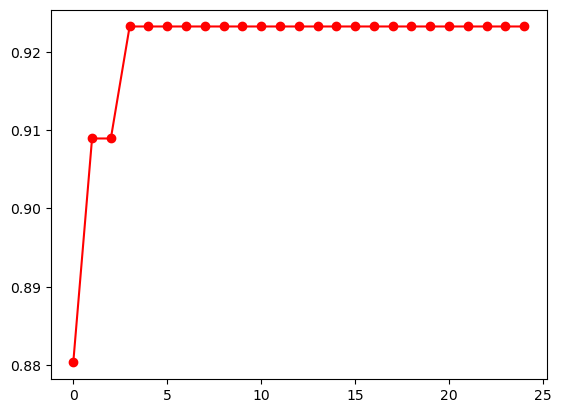

In [14]:
score_validation
plt.plot(score_validation, marker = 'o', color = 'r')

Nous constatons une très forte stagnation entre 7 et 20 pour le k. Nous allons tester notre modèle avec une optimisation entre 8 et 10 (qui semble présenter une légère hausse).

###### GridSearch CV

In [15]:
grid_param = {'n_neighbors':np.arange(8,15),
             'weights' : ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan', 'minkowski']}
grid = GridSearchCV(KNeighborsClassifier(), grid_param, cv = 5, verbose = 5)

In [16]:
# ici, on entraine la fonction
grid.fit(X_train, y_train)

# Obtenir le meilleur score selon nos choix d'hyperparamètres
print('Le meilleur score avec les hyperparamètres est de : ',grid.best_score_)

# Connaître les meilleurs paramètres
print('Les meilleurs hyperparamètres sont : ',grid.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.933 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.933 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=8, weights=uniform;, score=0.867 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=8, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=8, weights=distance;, score=0.933 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=8, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=8, weights=distance;, score=0.867 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=8, weights=distance;, score=0.867 to

[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.867 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=10, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=10, weights=uniform;, score=0.933 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=10, weights=uniform;, score=0.933 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=10, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=10, weights=uniform;, score=0.867 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=10, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighb

[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.867 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.867 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=12, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=12, weights=uniform;, score=0.933 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=12, weights=uniform;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_ne

In [17]:
# Création du modèle final avec les hyperparamètres
model_final = KNeighborsClassifier(metric='euclidean', n_neighbors=8, weights='uniform')
model_final.fit(X_train, y_train)

# Évaluation du modèle
print('Le taux de prédiction du modèle est de : ', model_final.score(X_train, y_train))

Le taux de prédiction du modèle est de :  0.92


###### Enregistrement du modèle optimisé

In [18]:
import pickle

# Sauvegarde du modèle
with open('model_KNN_streamlit.pkl', 'wb') as file:
    pickle.dump(model_final, file)

In [19]:
df

,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,NEW_DOC_KURT,...,NONLIVINGAREA_MODE,AMT_ANNUITY,BURO_CREDIT_TYPE_Mortgage_MEAN,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0,112426,0.0,0.522181,0.918919,22.0,76645.791409,1.294235,0.014808,20.0,...,0.050600,44149.5,0.000000,24.000,0,0,2529.066951,0,8539.830000,160390.363993
1,0,117075,5.0,0.522181,1.000000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,18729.0,0.000000,18.000,0,0,2529.066951,0,694.440000,0.000000
2,0,119392,0.0,0.522181,1.000000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,17649.0,0.000000,6.000,0,0,2529.066951,0,10512.630000,142537.500000
3,0,120209,30.0,0.522181,1.000000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,39645.0,0.500000,15.336,0,0,2529.066951,0,49.140000,855967.500000
4,0,126456,0.0,0.522181,1.000000,8.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,30339.0,0.000000,10.000,0,0,0.000000,0,3254.040000,100556.836000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,449846,0.0,0.522181,1.000000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,18099.0,0.000000,18.000,0,0,2529.066951,0,4931.685000,159813.000000
96,1,450901,0.0,0.522181,1.000000,0.0,76645.791409,1.294235,0.014808,20.0,...,0.000000,17451.0,0.000000,18.000,0,0,0.000000,0,11547.405000,168669.000000
97,1,452635,0.0,0.522181,1.073195,0.0,76645.791409,1.294235,0.014808,20.0,...,0.027023,18810.0,0.014232,4.000,0,0,2529.066951,0,5198.165134,160390.363993
98,0,454602,0.0,0.566667,1.000000,6.0,0.000000,0.000000,0.030600,20.0,...,0.000000,35149.5,0.000000,18.000,0,0,2529.066951,0,31.275000,0.000000


# 

### III. Conclusion étape KNN

En conclusion, l'utilisation du modèle de KNN pour notre projet Streamlit a été essentielle pour atteindre notre objectif, qui était de trouver le client le plus proche de celui sélectionné. Cependant, il est important de noter que le modèle peut présenter des résultats mitigés en raison d'un problème de déséquilibre des classes. Ce déséquilibre peut affecter la précision globale du modèle.

Pour améliorer les performances du modèle, il est recommandé d'explorer des techniques d'optimisation. En effectuant une optimisation appropriée, nous pouvons mieux comprendre les caractéristiques des données et améliorer la précision du modèle. Cela nous permettra d'obtenir des résultats plus fiables et précis lors de la recherche du client le plus proche.

En tant que complément pour le dashboard, cette partie sur l'utilisation du modèle de KNN et son optimisation fournira des informations supplémentaires importantes. Les utilisateurs pourront ainsi avoir une vision plus complète et détaillée de la performance du modèle et de ses limitations. Cela les aidera à prendre des décisions éclairées lors de l'utilisation de l'application Streamlit.